In [1]:
from simulation.model import PathFindingModel
import mesa
import analytics.ranking_measures as measures
import pandas as pd

In [2]:
def group_summary(df, measure_func):
    group_statistics = {
        'zone':df['goal_zones'].iloc[0],
        'alg':df['path_planning_alg'].iloc[0],
        'goal_pop':df['intention_num'].iloc[0],
        'seed':df['seed'].iloc[0],
        'obstacle_used':df['obstacle_used'].iloc[0],
        'segmentation':measure_func(df['Segment_ranking'],ground_truth_position=df['true_intention'].iloc[0]),
        'masters':measure_func(df['Masters_ranking'],ground_truth_position=df['true_intention'].iloc[0]),
        'mirroring':measure_func(df['Mirroring_ranking'],ground_truth_position=df['true_intention'].iloc[0])}
    return pd.Series(group_statistics)

def df_transform(raw_df, measure_func):
    run_statistics = raw_df.groupby('RunId').apply(lambda x: group_summary(x, measure_func))
    # run_statistics.set_index(['zone','goal_pop','seed','alg','obstacle_used'], inplace=True)
    return run_statistics


## Experiment 1: the impact of number of intentions

### Single goal, two intentions: to the true destination with or without obstacles


In [3]:
params = {"width":20,"height":20,"obs_num":40,"goal_zones":'0',"seed":range(0,1000),"path_planning_alg":0,"intention_profile":1}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 500,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)
results_df_e1_1 = pd.DataFrame(results)

100%|██████████| 1000/1000 [34:12<00:00,  2.05s/it] 


In [4]:
e1_1_final_correctness = df_transform(results_df_e1_1, measures.final_correctness)
e1_1_fc_long = pd.melt(e1_1_final_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Final Correctness')
e1_1_fc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e1_1_gc = df_transform(results_df_e1_1, measures.correctness)
e1_1_gc_long = pd.melt(e1_1_gc.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='General Correctness')
e1_1_gc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e1_1_cc = df_transform(results_df_e1_1, measures.last_change)
e1_1_cc_long = pd.melt(e1_1_cc.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Convergence Correctness')
e1_1_cc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e1_1_stability = df_transform(results_df_e1_1, measures.stability)
e1_1_stability_long = pd.melt(e1_1_stability.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Stability')
e1_1_stability_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e1_1 = pd.concat([e1_1_fc_long, e1_1_gc_long, e1_1_cc_long, e1_1_stability_long], axis=1)
e1_1.reset_index(names=['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e1_1_long = pd.melt(e1_1, id_vars=['zone','goal_pop','seed','alg','obstacle_used','measure'], value_vars=['Final Correctness','General Correctness','Convergence Correctness','Stability'], var_name='metric', value_name='value')

In [5]:
e1_1_long.to_csv('results/e1_1.csv')

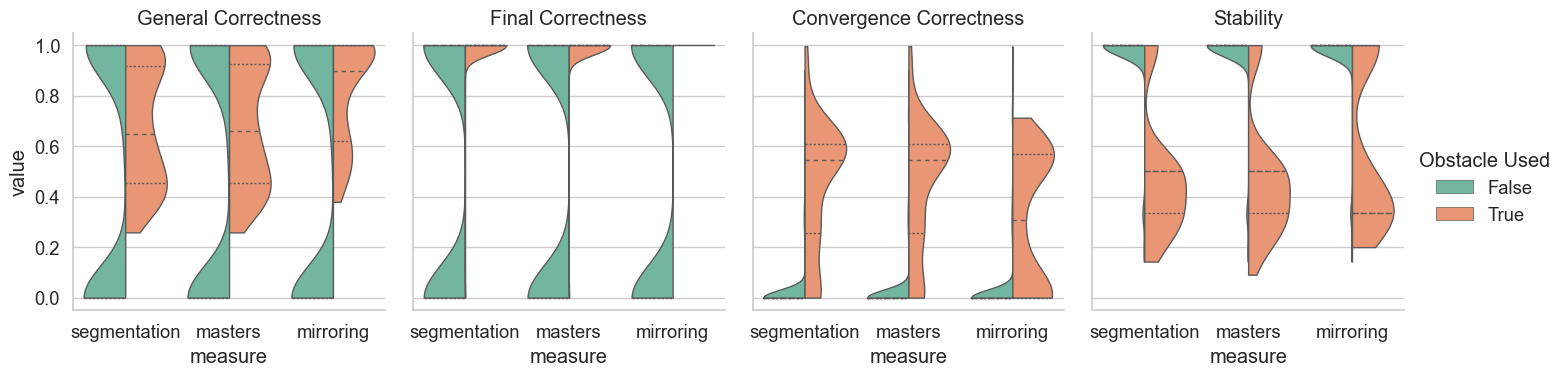

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(e1_1_long, col="metric", height=4, aspect = 0.9, col_order=['General Correctness','Final Correctness','Convergence Correctness','Stability'])
g.map(sns.violinplot,"measure", "value", "obstacle_used",split=True, cut=0, order=['segmentation','masters','mirroring'],hue_order=[False,True],palette='Set2',linewidth=1,inner='quartile',scale='width')
g.set_titles("{col_name}")
g.add_legend(title='Obstacle Used')


In [7]:
g.savefig('results/e1_1.pdf', format='pdf')


### Multiple goals, variable number of intentions: adding potential destinations

In [8]:
params = {"width":20,"height":20,"obs_num":40,"goal_zones":['0,0','0,0,0,0,0,0','0,0,0,0,0,0,0,0,0,0'],"seed":range(0,1000),"path_planning_alg":0,"intention_profile":1}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 500,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)
results_df_e1_2 = pd.DataFrame(results)

 79%|███████▊  | 2356/3000 [9:11:00<1:19:14,  7.38s/it]  

In [ ]:
e1_2_final_correctness = df_transform(results_df_e1_2, measures.final_correctness)
e1_2_final_correctness['destinition_pop'] = e1_2_final_correctness['zone'].apply(lambda x: len(x.split(',')))
e1_2_fc_long = pd.melt(e1_2_final_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used','destinition_pop'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Final Correctness')
e1_2_fc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], inplace=True)
e1_2_general_correctness = df_transform(results_df_e1_2, measures.correctness)
e1_2_general_correctness['destinition_pop'] = e1_2_general_correctness['zone'].apply(lambda x: len(x.split(',')))
e1_2_gc_long = pd.melt(e1_2_general_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used','destinition_pop'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='General Correctness')
e1_2_gc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], inplace=True)
e1_2_convergence_correctness = df_transform(results_df_e1_2, measures.last_change)
e1_2_convergence_correctness['destinition_pop'] = e1_2_convergence_correctness['zone'].apply(lambda x: len(x.split(',')))
e1_2_cc_long = pd.melt(e1_2_convergence_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used','destinition_pop'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Convergence Correctness')
e1_2_cc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], inplace=True)
e1_2_stability = df_transform(results_df_e1_2, measures.stability)
e1_2_stability['destinition_pop'] = e1_2_stability['zone'].apply(lambda x: len(x.split(',')))
e1_2_stability_long = pd.melt(e1_2_stability.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used','destinition_pop'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Stability')
e1_2_stability_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], inplace=True)
e1_2 = pd.concat([e1_2_fc_long, e1_2_gc_long, e1_2_cc_long, e1_2_stability_long], axis=1)
e1_2.reset_index(names=['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], inplace=True)
e1_2_long = pd.melt(e1_2, id_vars=['zone','goal_pop','seed','alg','obstacle_used','destinition_pop','measure'], value_vars=['Final Correctness','General Correctness','Convergence Correctness','Stability'], var_name='metric', value_name='value')


In [ ]:
e1_2_long.to_csv('results/e1_2.csv')

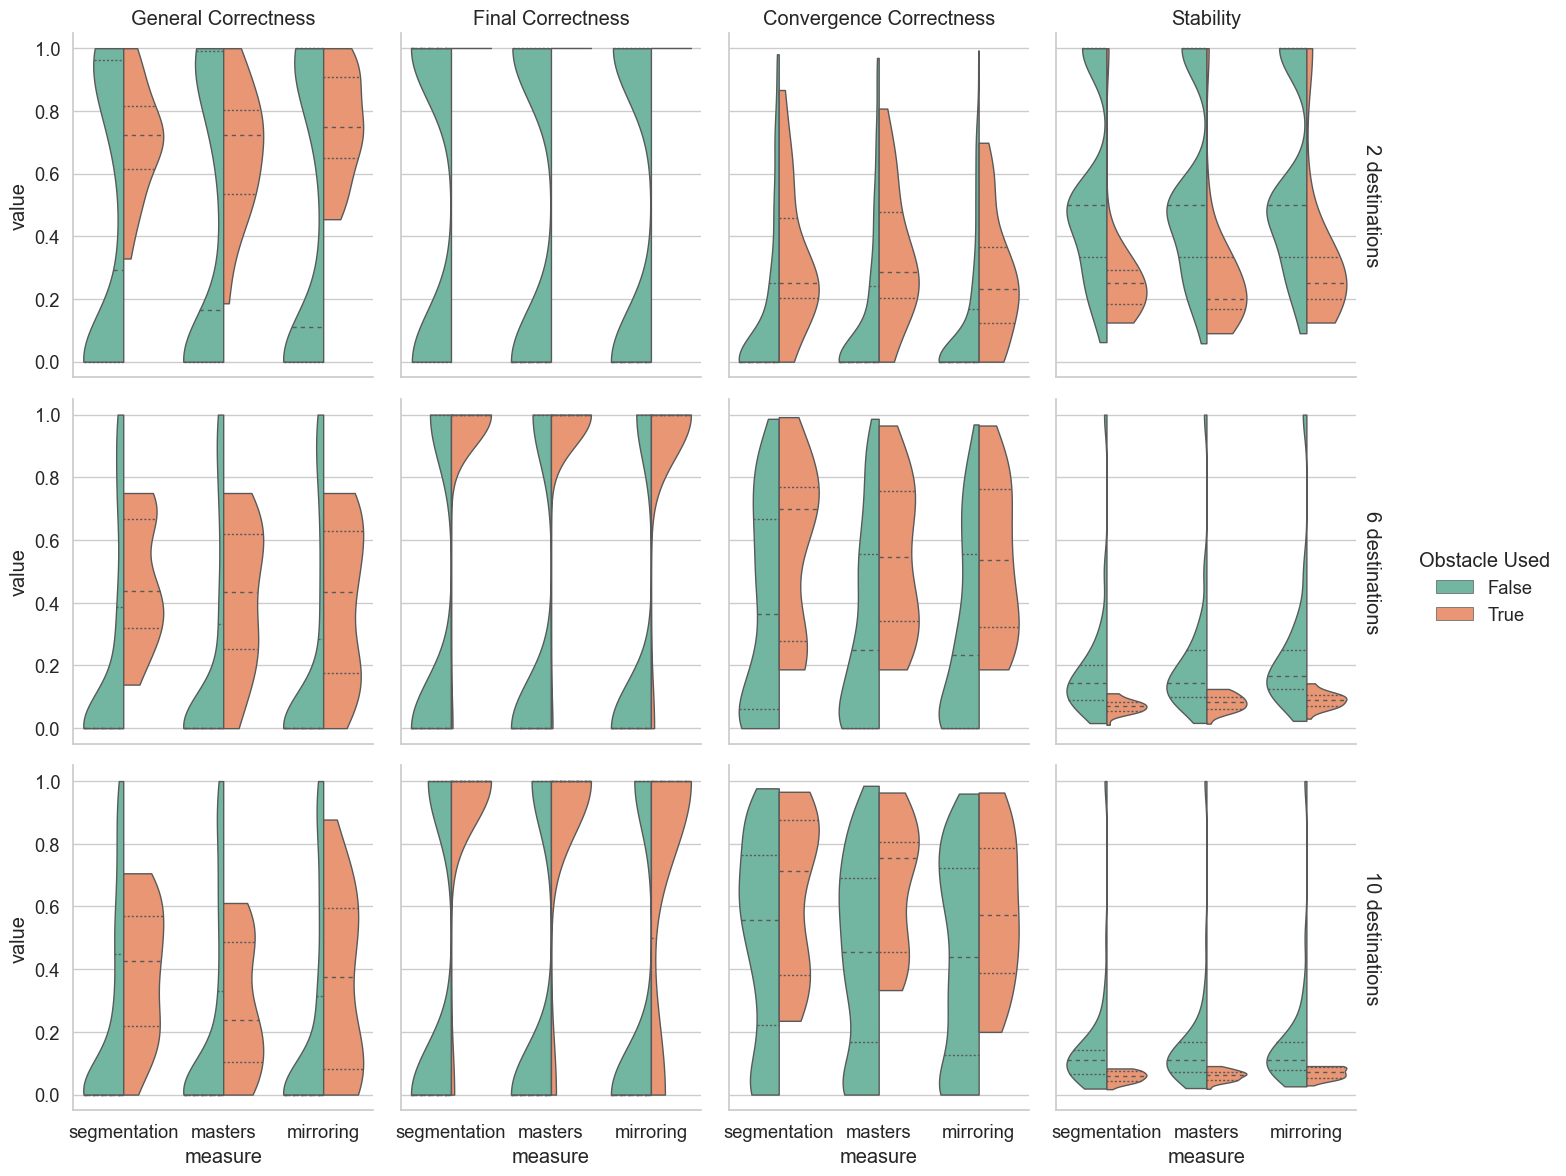

In [ ]:
sns.set(font_scale=1.2)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(e1_2_long,row="destinition_pop", col="metric", height=4, aspect = 0.9, col_order=['General Correctness','Final Correctness','Convergence Correctness','Stability'], margin_titles=True)
g.map(sns.violinplot,"measure", "value", "obstacle_used",split=True, cut=0, order=['segmentation','masters','mirroring'],hue_order=[False,True],palette='Set2',linewidth=1,inner='quartile',scale='width')
g.set_titles(col_template="{col_name}", row_template="{row_name} destinations")
g.add_legend(title='Obstacle Used')

In [ ]:
g.savefig('results/e1_2.pdf', format='pdf')

## Experiment 2: the impact of destination destribution
comparing three scenarios:
1. Uniform distribution in zone 2 only
2. Uniform distribution in zone 1,2,3
3. Uniform distribution in zone 0

In [ ]:
params = {"width":20,"height":20,"obs_num":40,"goal_zones":['2,0,0,0','2,2,2,2','2,1,2,3'],"seed":range(0,1000),"path_planning_alg":0,"intention_profile":1}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 1000,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)
results_df_e2 = pd.DataFrame(results)

100%|██████████| 900/900 [1:09:45<00:00,  4.65s/it]


In [ ]:
e2_final_correctness = df_transform(results_df_e2, measures.final_correctness)
e2_fc_long  = pd.melt(e2_final_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Final Correctness')
e2_fc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e2_general_correctness = df_transform(results_df_e2, measures.correctness)
e2_gc_long  = pd.melt(e2_general_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='General Correctness')
e2_gc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e2_convergence_correctness = df_transform(results_df_e2, measures.last_change)
e2_cc_long  = pd.melt(e2_convergence_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Convergence Correctness')
e2_cc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e2_stability = df_transform(results_df_e2, measures.stability)
e2_stability_long  = pd.melt(e2_stability.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Stability')
e2_stability_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e2 = pd.concat([e2_fc_long, e2_gc_long, e2_cc_long, e2_stability_long], axis=1)
e2.reset_index(names=['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e2_long = pd.melt(e2, id_vars=['zone','goal_pop','seed','alg','obstacle_used','measure'], value_vars=['Final Correctness','General Correctness','Convergence Correctness','Stability'], var_name='metric', value_name='value')

In [ ]:
e2_long.to_csv('results/e2.csv')

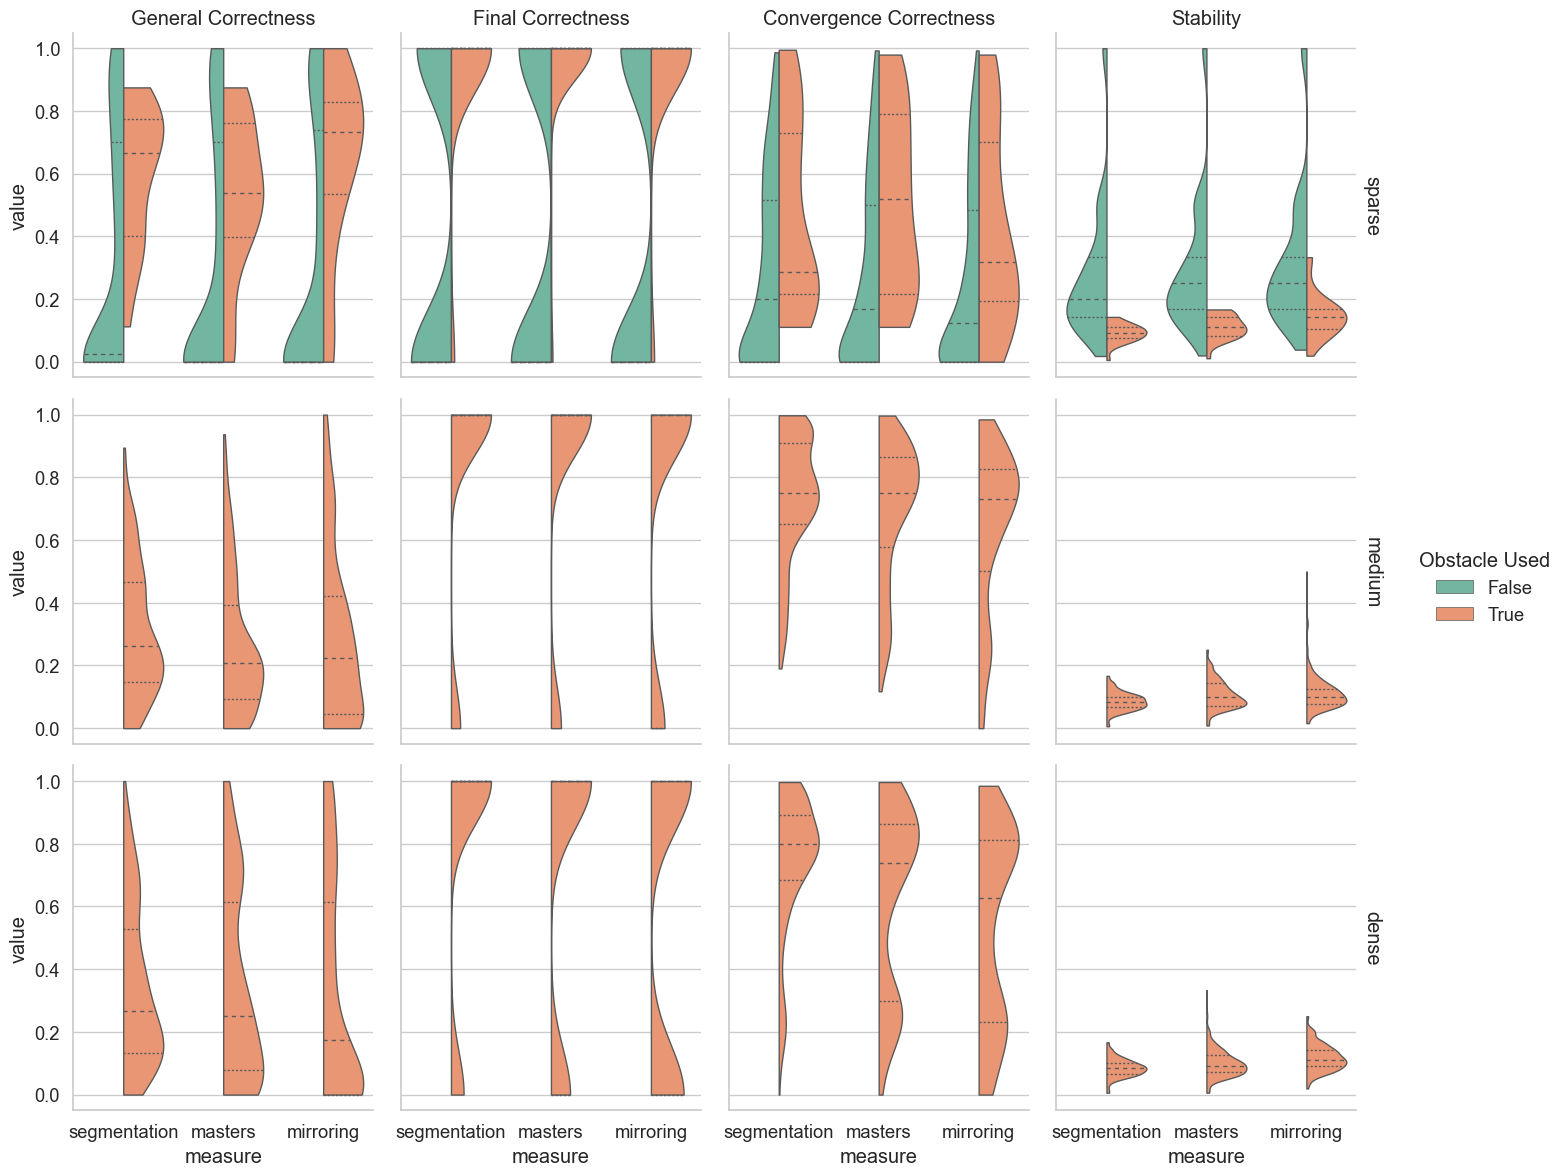

In [ ]:
e2_long['zone'] = e2_long['zone'].replace({'0,0,0,0':'sparse','2,2,2,2':'dense','2,1,2,3':'medium'})
sns.set(font_scale=1.2)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(e2_long,row="zone", col="metric", height=4, aspect = 0.9, col_order=['General Correctness','Final Correctness','Convergence Correctness','Stability'], margin_titles=True, row_order=['sparse','medium','dense'])
g.map(sns.violinplot,"measure", "value", "obstacle_used",split=True, cut=0, order=['segmentation','masters','mirroring'],hue_order=[False,True],palette='Set2',linewidth=1,inner='quartile',scale='width')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Obstacle Used')

In [ ]:
g.savefig('results/e2.pdf', format='pdf')

## Experiment 3: the impact of movement patterns

In [ ]:
params = {"width":20,"height":20,"obs_num":40,"goal_zones":'2,2,2,2',"seed":range(0,1000),"path_planning_alg":[0,1,2],"intention_profile":1}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 1000,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)
results_df_e3 = pd.DataFrame(results)

100%|██████████| 1500/1500 [1:46:01<00:00,  4.24s/it]  


In [ ]:
e3_final_correctness = df_transform(results_df_e3, measures.final_correctness)
e3_fc_long  = pd.melt(e3_final_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Final Correctness')
e3_fc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e3_general_correctness = df_transform(results_df_e3, measures.correctness)
e3_gc_long  = pd.melt(e3_general_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='General Correctness')
e3_gc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e3_convergence_correctness = df_transform(results_df_e3, measures.last_change)
e3_cc_long  = pd.melt(e3_convergence_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Convergence Correctness')
e3_cc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e3_stability = df_transform(results_df_e3, measures.stability)
e3_stability_long  = pd.melt(e3_stability.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Stability')
e3_stability_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e3 = pd.concat([e3_fc_long, e3_gc_long, e3_cc_long, e3_stability_long], axis=1)
e3.reset_index(names=['zone','goal_pop','seed','alg','obstacle_used','measure'], inplace=True)
e3_long = pd.melt(e3, id_vars=['zone','goal_pop','seed','alg','obstacle_used','measure'], value_vars=['Final Correctness','General Correctness','Convergence Correctness','Stability'], var_name='metric', value_name='value')

In [ ]:
e3_long.to_csv('results/e3.csv')

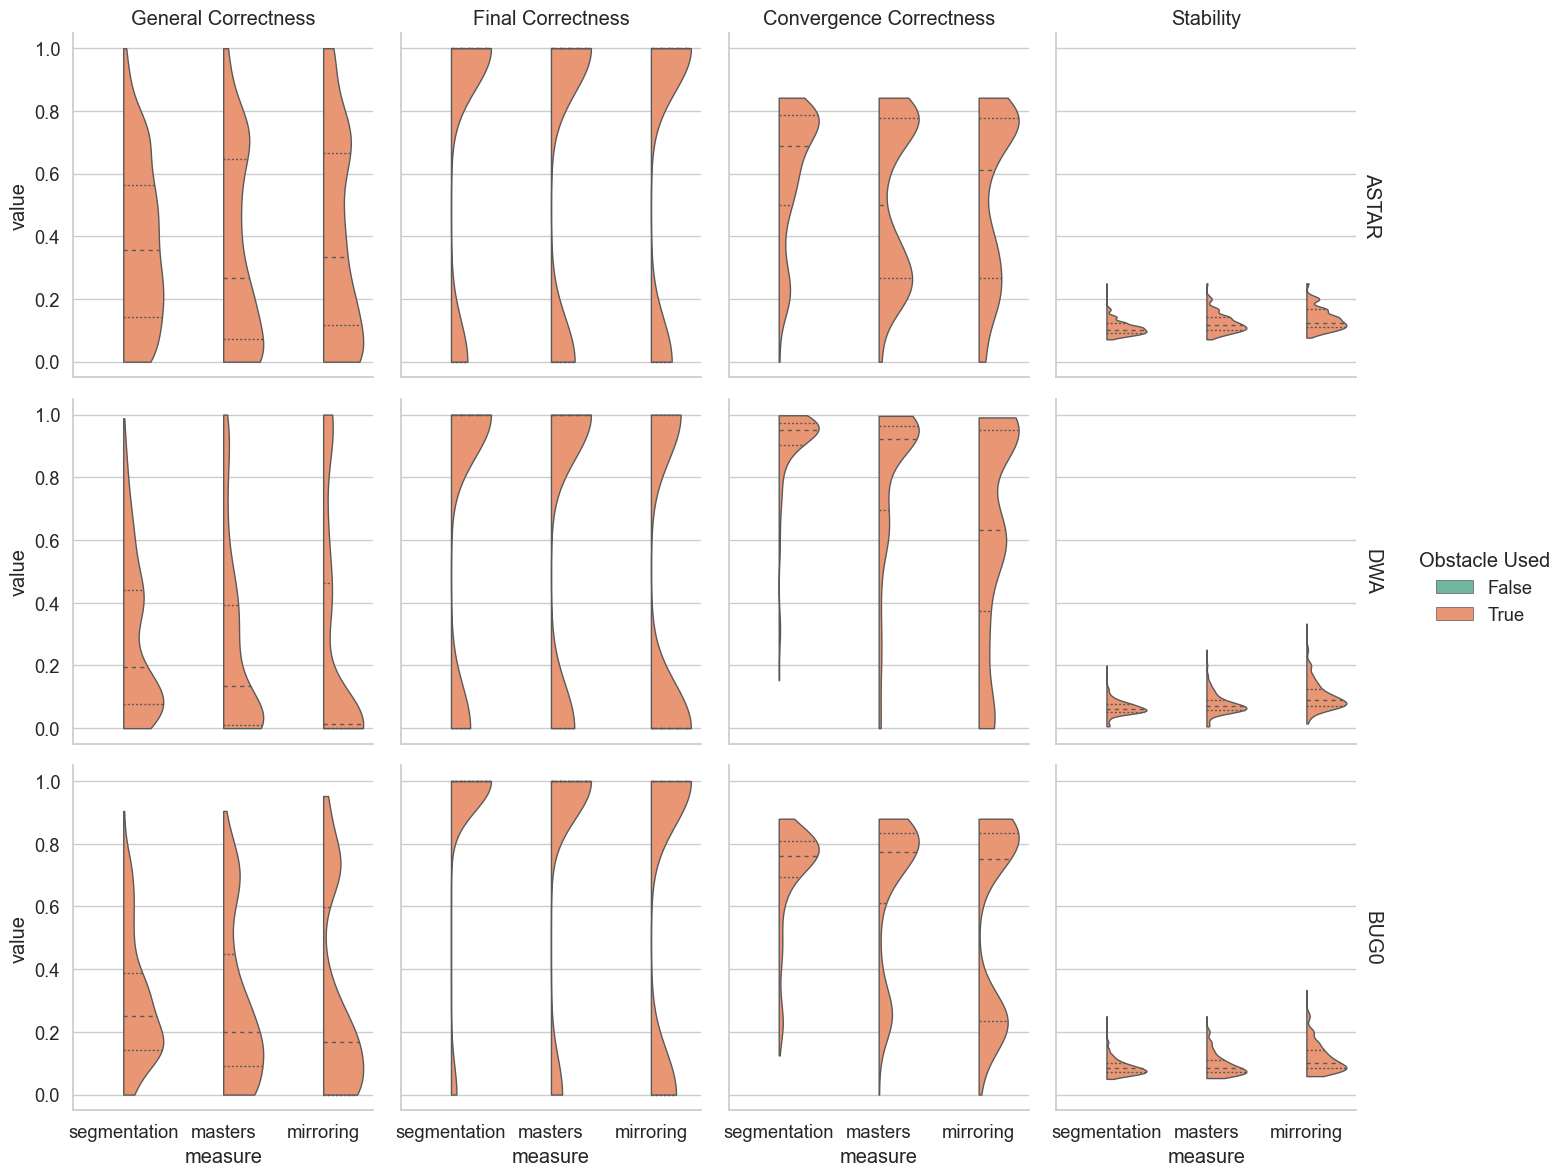

In [ ]:
e3_long['alg'] = e3_long['alg'].replace({0:'DWA',1:'ASTAR',2:'BUG0'})
sns.set(font_scale=1.2)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(e3_long,row="alg", col="metric", height=4, aspect = 0.9, col_order=['General Correctness','Final Correctness','Convergence Correctness','Stability'], margin_titles=True, row_order=['ASTAR','DWA','BUG0'])
g.map(sns.violinplot,"measure", "value", "obstacle_used",split=True, cut=0, order=['segmentation','masters','mirroring'],hue_order=[False,True],palette='Set2',linewidth=1,inner='quartile',scale='width')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Obstacle Used')

#### Final correctness

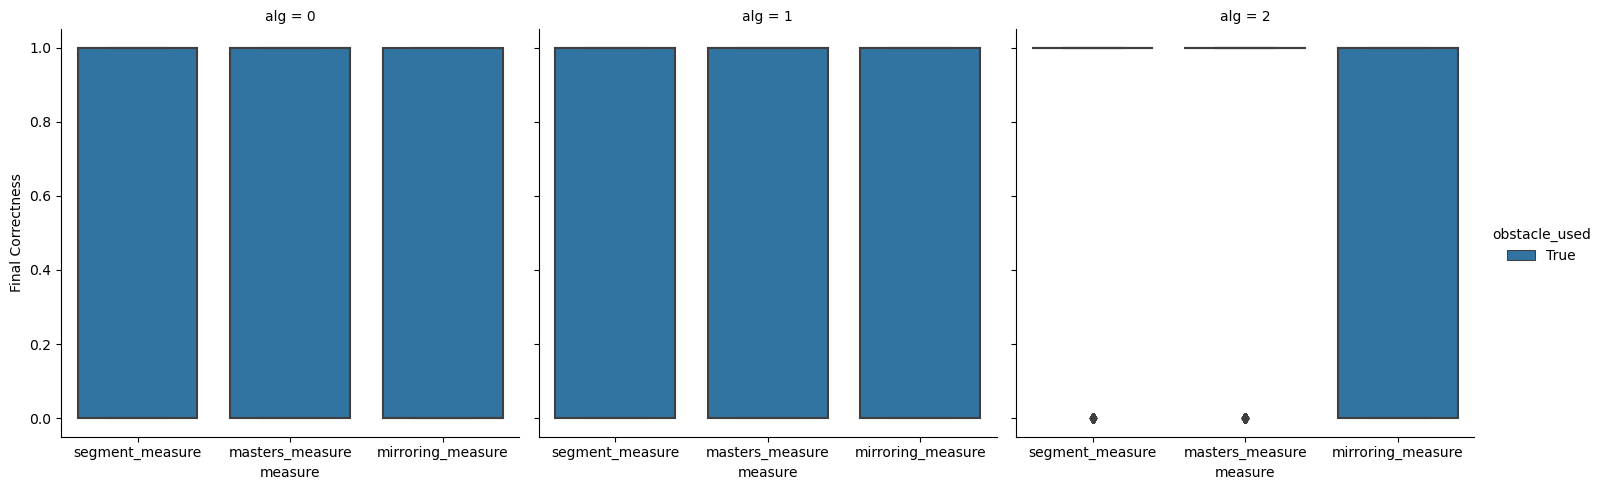

In [ ]:
e3_final_correctness = df_transform(results_df_e3, measures.final_correctness)
e3_fc_long  = pd.melt(e3_final_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segment_measure','masters_measure','mirroring_measure'], var_name='measure', value_name='Final Correctness')
sns.catplot(data=e3_fc_long, x='measure', y='Final Correctness', hue='obstacle_used', col='alg', kind='box')

#### General correctness

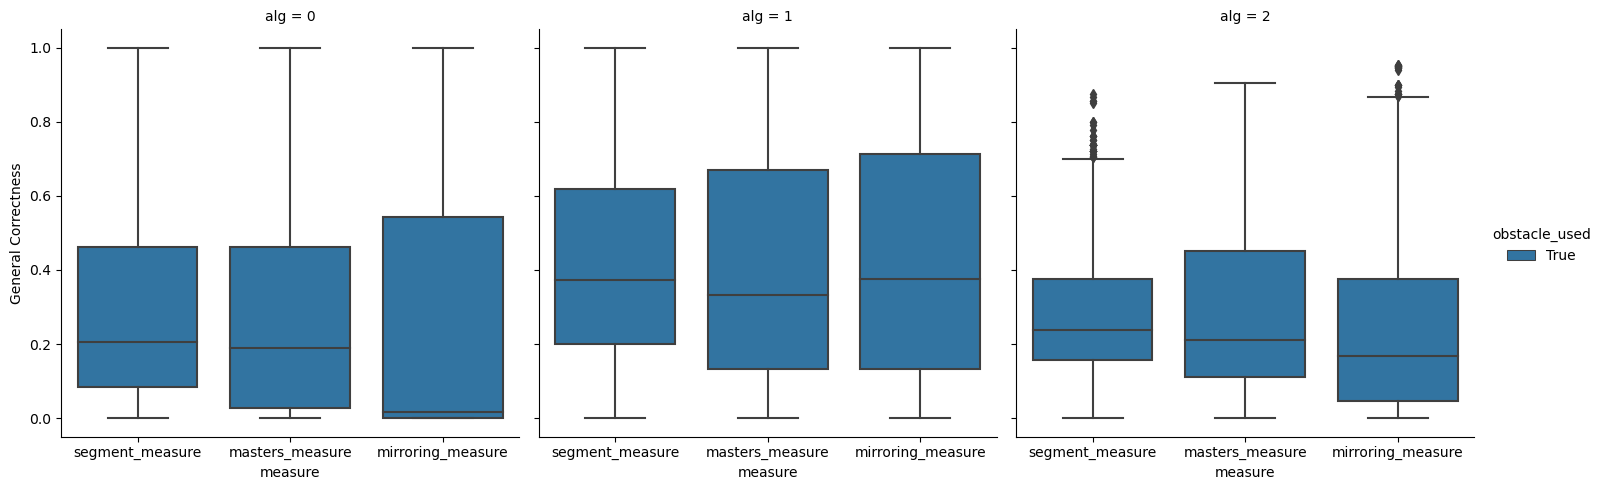

In [ ]:
e3_general_correctness = df_transform(results_df_e3, measures.correctness)
e3_gc_long  = pd.melt(e3_general_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segment_measure','masters_measure','mirroring_measure'], var_name='measure', value_name='General Correctness')
sns.catplot(data=e3_gc_long, x='measure', y='General Correctness', hue='obstacle_used', col='alg', kind='box')

#### Convergence Correctness

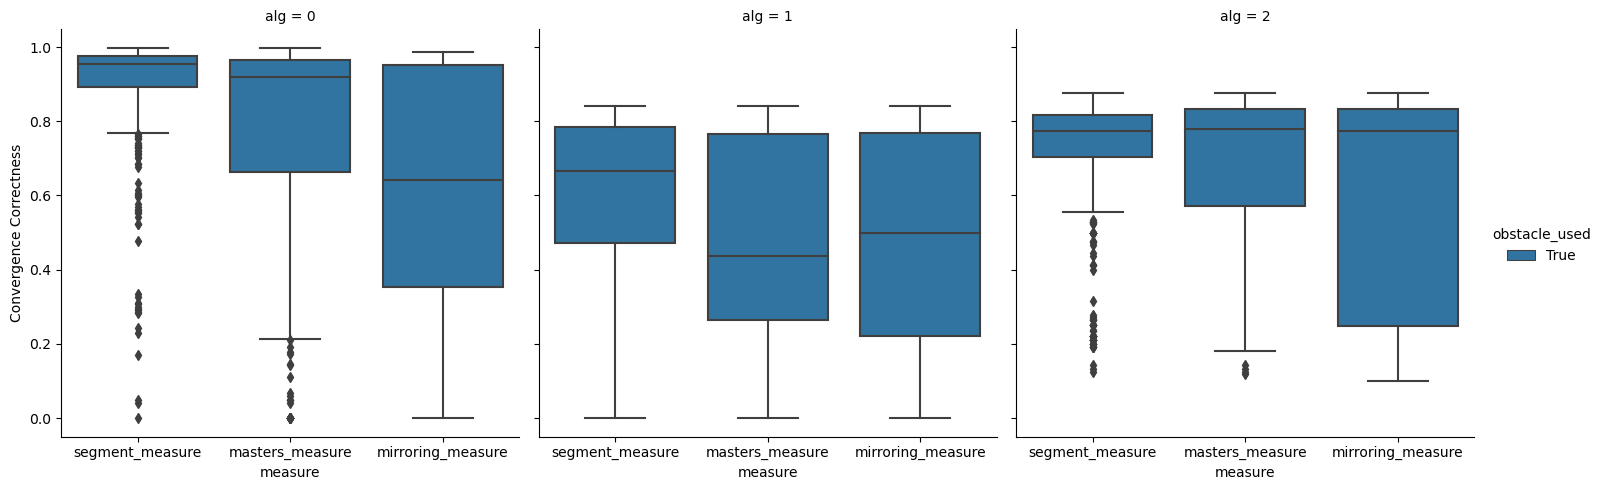

In [ ]:
e3_convergence_correctness = df_transform(results_df_e3, measures.last_change)
e3_cc_long  = pd.melt(e3_convergence_correctness.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segment_measure','masters_measure','mirroring_measure'], var_name='measure', value_name='Convergence Correctness')
sns.catplot(data=e3_cc_long, x='measure', y='Convergence Correctness', hue='obstacle_used', col='alg', kind='box')

#### Stability

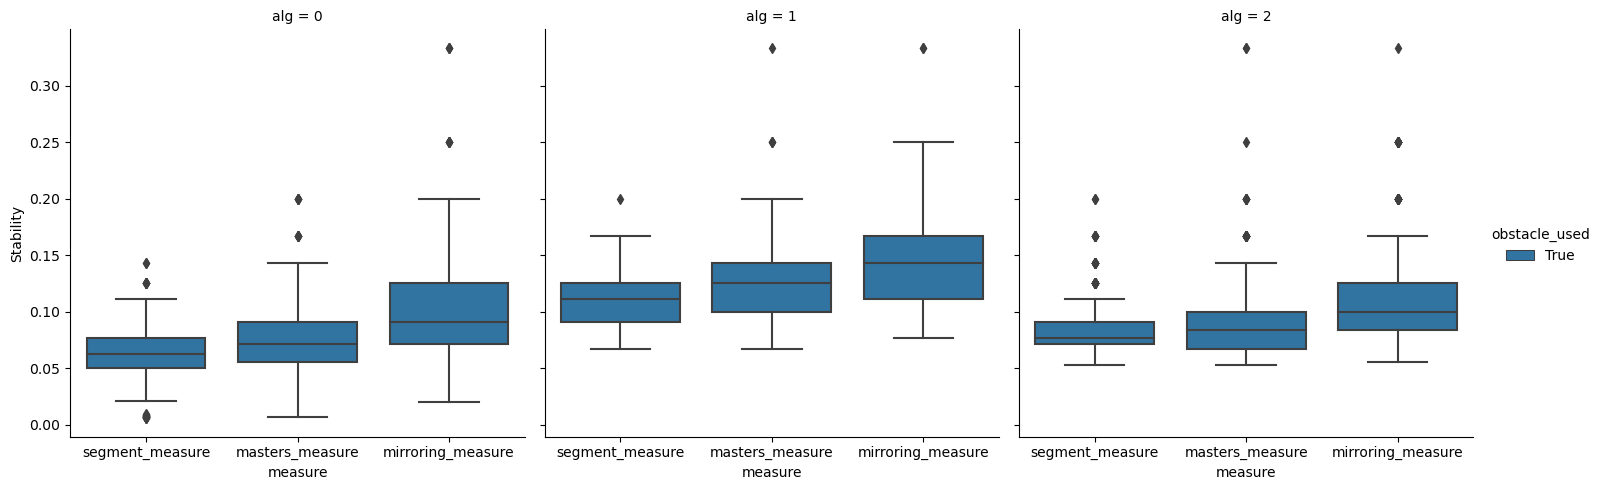

In [ ]:
e3_stability = df_transform(results_df_e3, measures.stability)
e3_stability_long  = pd.melt(e3_stability.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used'], value_vars=['segment_measure','masters_measure','mirroring_measure'], var_name='measure', value_name='Stability')
sns.catplot(data=e3_stability_long, x='measure', y='Stability', hue='obstacle_used', col='alg', kind='box')